## EDA and Data Preprocessing

According to the README.md from https://github.com/zalandoresearch/fashion-mnist, we can use this function from Tensorflow to load the dataset. And it's already split for us.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

(X_train, y_train), (X_test, y_test) =  tf.keras.datasets.fashion_mnist.load_data()

2024-10-26 15:22:58.032448: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 15:22:59.060970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(f"Train set shape: {X_train.shape, y_train.shape}\nTest set shape: {X_test.shape, y_test.shape}")

Train set shape: ((60000, 28, 28), (60000,))
Test set shape: ((10000, 28, 28), (10000,))


It would be more convenient to have the image as a flat vector, i.e. a 784-dimension Numpy array.

In [3]:
X_train: np.ndarray = X_train.reshape(X_train.shape[0], 784)
X_test: np.ndarray = X_test.reshape(X_test.shape[0], 784)

Let's have a look at some image.

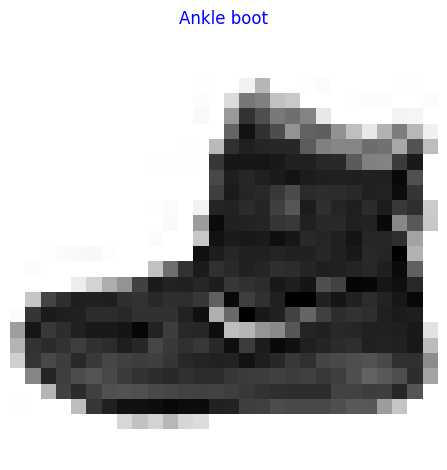

In [42]:
class_name = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

def plot_image(image_data: np.ndarray, label:int):
    image_data = image_data.reshape(28, 28)
    plt.imshow(image_data, cmap="binary")
    plt.title(class_name[label], color = "blue")
    plt.axis("off")
    plt.tight_layout()

plot_image(X_train[0], y_train[0])
plt.show()

An image doesn't tell very much though. Let's have a peek at the first 64 images from the train set.

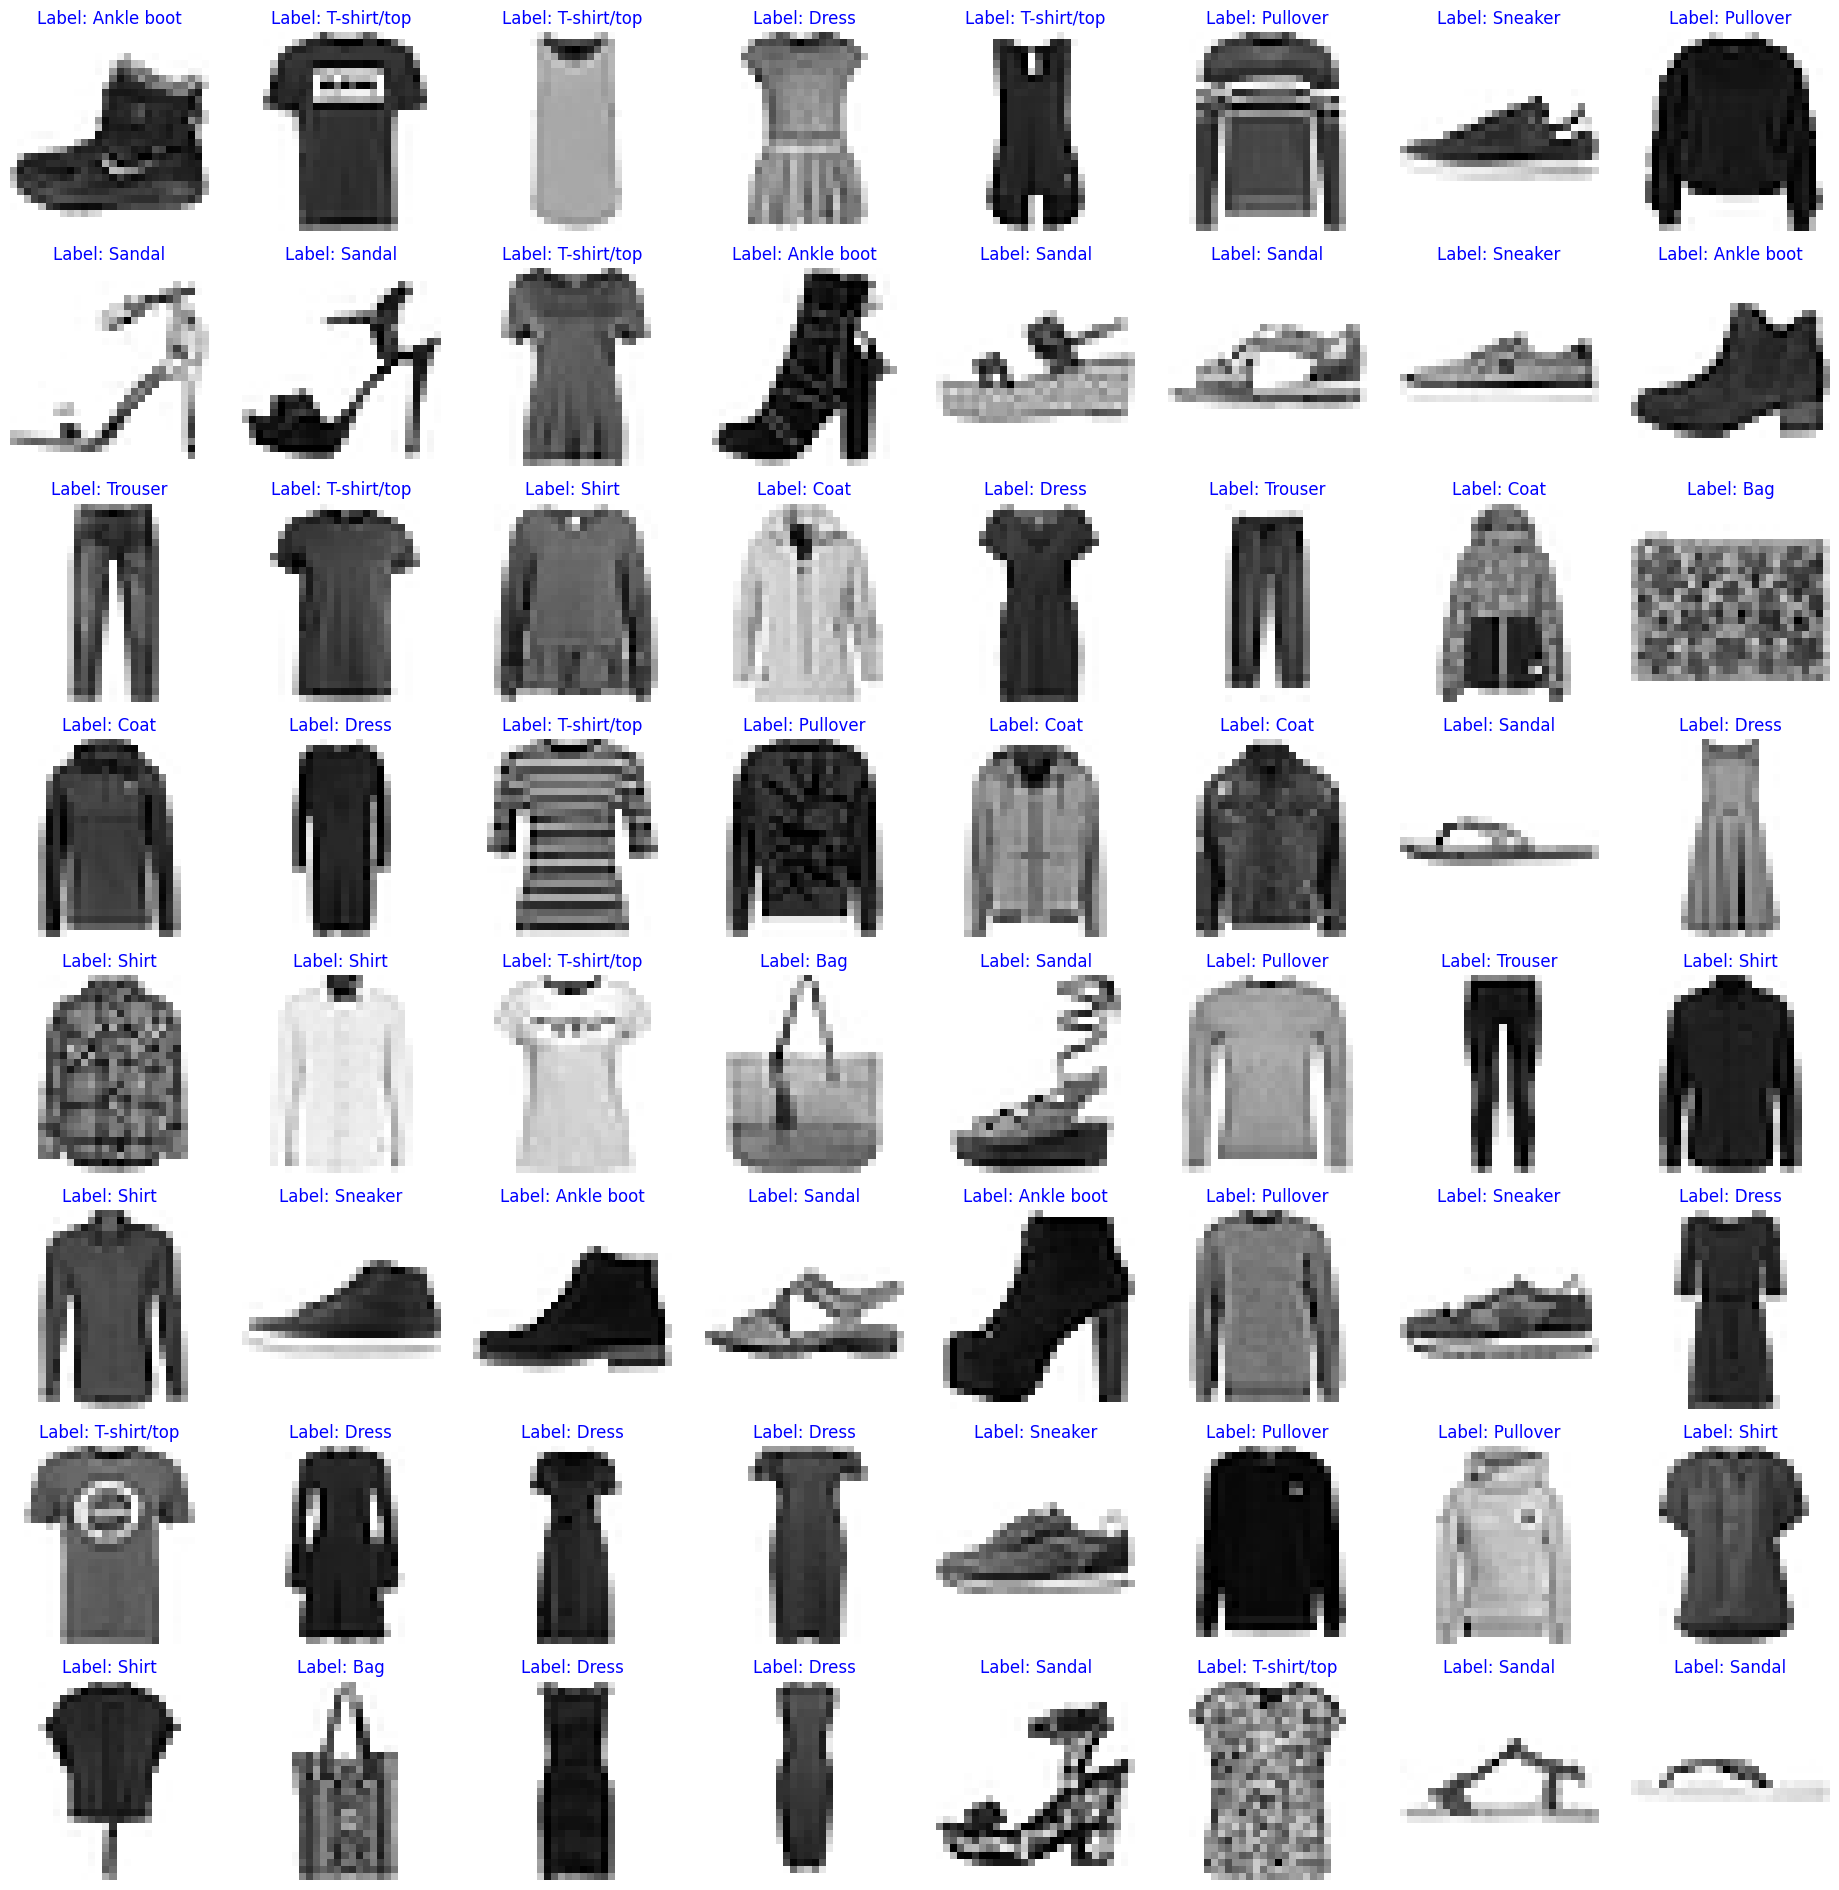

In [41]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(19, 19))
for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(X_train[index], y_train[index])

plt.show()

From their documentation, the data is already cleaned for us, so no image preprocessing is required (I don't think I'm better than the expert at this).

In [6]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])),
 (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
  array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])))

There are ten classes, with the exact same amount across all of them in both train and test set.
Here are the class names and their corresponding indices:

| Index | Class Name    |
|-------|---------------|
| 0     | T-shirt/top   |
| 1     | Trouser       |
| 2     | Pullover      |
| 3     | Dress         |
| 4     | Coat          |
| 5     | Sandal        |
| 6     | Shirt         |
| 7     | Sneaker       |
| 8     | Bag           |
| 9     | Ankle boot    |

In [8]:
# Optionally, here are the scaled version of the X sets, though I think you shouldn't use it
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

## Train Linear Model - Logistic Regression

Because the whole data set is too large, then I will fine tune only 6000 images from it. Too balance classes in the training subset, I choose randomly for each class 600 images

In [9]:
def take_training_subset(X_train, y_train, subset_ratio=0.4):
    classes = np.unique(y_train)  # get number of classes
    num_classes = len(classes)
    num_samples_per_class = int(len(X_train) * subset_ratio / num_classes)
    
    X_subset = np.empty((num_samples_per_class * num_classes, X_train.shape[1]), dtype=X_train.dtype)
    y_subset = np.empty(num_samples_per_class * num_classes, dtype=y_train.dtype)
    
    for i, class_label in enumerate(classes):
        class_indices = np.where(y_train == class_label)[0]
        chosen_indices = np.random.choice(class_indices, size=num_samples_per_class, replace=False)
        
        start = i * num_samples_per_class
        end = start + num_samples_per_class
        X_subset[start:end] = X_train[chosen_indices]
        y_subset[start:end] = y_train[chosen_indices]
    
    return X_subset, y_subset

In [10]:
X_train_log_reg = X_train_scaled
X_train_log_reg, y_train_log_reg = take_training_subset(X_train_log_reg, y_train)
print(len(X_train_log_reg))

24000


Training with native logistic regression first

In [11]:
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(random_state=42, max_iter=5000)
acc_cross = cross_val_score(log_reg, X_train_log_reg, y_train_log_reg, cv=3, n_jobs=-1)
print(f"Accuracy of native logistic regression: {np.mean(acc_cross):.2f}")

Accuracy of native logistic regression: 0.82


## Tuning Logistic Regression Model

I use `RandomizedSearchCV` for wide range of hyperparameter, then use `GridSearchCV` to search the best.

Parameters will be fine tune are:
- `C`: regularization, because it helps prevent **overfiting**, if it too small, model will be overfit, otherwise model will be underfit.
- `solver`: specifies the optimization algorithm used for training. Choosing the right solver can improve convergence speed and stability. 
  - `lbfgs`
  - `newton-cg`
- `penalty`: Type of regularization used to prevent overfitting, common values are: `l1`, `l2`. On complex dataset like **MIST FASHION** choosing the right penalty will help the model balance learning the data well without overfiting.
  - L1: simplifies the model by removing unimportance features, potentially improving speed.
  - L2: keeps all features but with smaller weights, useful when each feature has unique significance.

But requirement is keep all 784 features, then choose `penalty` = `l2`.

In [12]:
from sklearn.model_selection import GridSearchCV

fine_tune_log_reg = LogisticRegression(random_state=42, max_iter=5000)
LRparam_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs'],
    'penalty': ['l2'],
}
LR_search = GridSearchCV(
    estimator=fine_tune_log_reg,
    param_grid=LRparam_grid,
    verbose=3,
    refit=True,
    cv=3
)

LR_search.fit(X_train_log_reg, y_train_log_reg)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END C=0.001, penalty=l2, solver=newton-cg;, score=0.845 total time=  10.9s
[CV 2/3] END C=0.001, penalty=l2, solver=newton-cg;, score=0.840 total time=  12.8s
[CV 3/3] END C=0.001, penalty=l2, solver=newton-cg;, score=0.843 total time=  11.1s
[CV 1/3] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.845 total time=  10.9s
[CV 2/3] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.840 total time=  10.4s
[CV 3/3] END .C=0.001, penalty=l2, solver=lbfgs;, score=0.842 total time=  13.3s
[CV 1/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.852 total time=  26.6s
[CV 2/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.854 total time=  23.2s
[CV 3/3] END C=0.01, penalty=l2, solver=newton-cg;, score=0.852 total time=  20.4s
[CV 1/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.852 total time=  18.2s
[CV 2/3] END ..C=0.01, penalty=l2, solver=lbfgs;, score=0.855 total time=  22.0s
[CV 3/3] END ..C=0.01, penalty=l2

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs']},
             verbose=3)

## Evaluate Logistic Regression Model

Train all training data, then evaluate on test set with metrics

Metrics:
- Accuracy
- Precision
- Recall
- F1 Score

In [15]:
best_params = LR_search.best_params_
print(best_params)
fine_tuned_model = LogisticRegression(**best_params, max_iter=10000, random_state=42)
fine_tuned_model.fit(X_train_scaled, y_train) # the whole data set
y_pred_log_reg = fine_tuned_model.predict(X_test_scaled)

{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [16]:
import joblib
joblib.dump(fine_tuned_model, 'logistic_model.joblib')

['logistic_model.joblib']

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
acc_score = accuracy_score(y_test, y_pred_log_reg)
prec_score = precision_score(y_test, y_pred_log_reg, average='macro')
rec_score = recall_score(y_test, y_pred_log_reg, average='macro')
f1 = f1_score(y_test, y_pred_log_reg, average='macro')

print(f"Accuracy on test set: {acc_score:.2f}")
print(f"Precision score on test set: {prec_score:.2f}")
print(f"Recall score on test set: {rec_score:.2f}")
print(f"f1 score on test set: {f1:.2f}")

Accuracy on test set: 0.85
Precision score on test set: 0.85
Recall score on test set: 0.85
f1 score on test set: 0.85


In [19]:
cm = confusion_matrix(y_test, y_pred_log_reg)

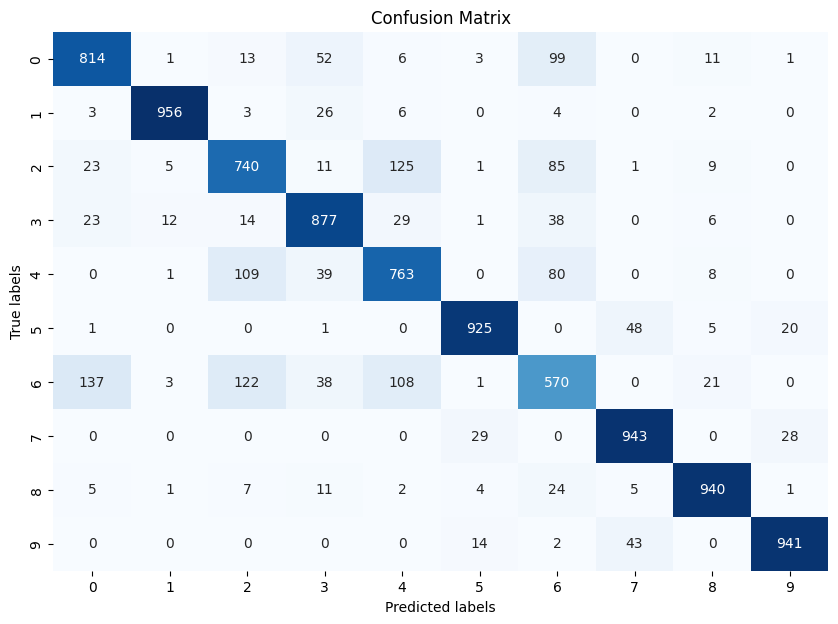

In [20]:
# plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar = False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Discuss about Logistic Regression with observed patterns

In [25]:
wrong_indexes = np.where(y_test != y_pred_log_reg)[0]
print(f"There are {len(wrong_indexes)} wrong predicted cases")

There are 1531 wrong predicted cases


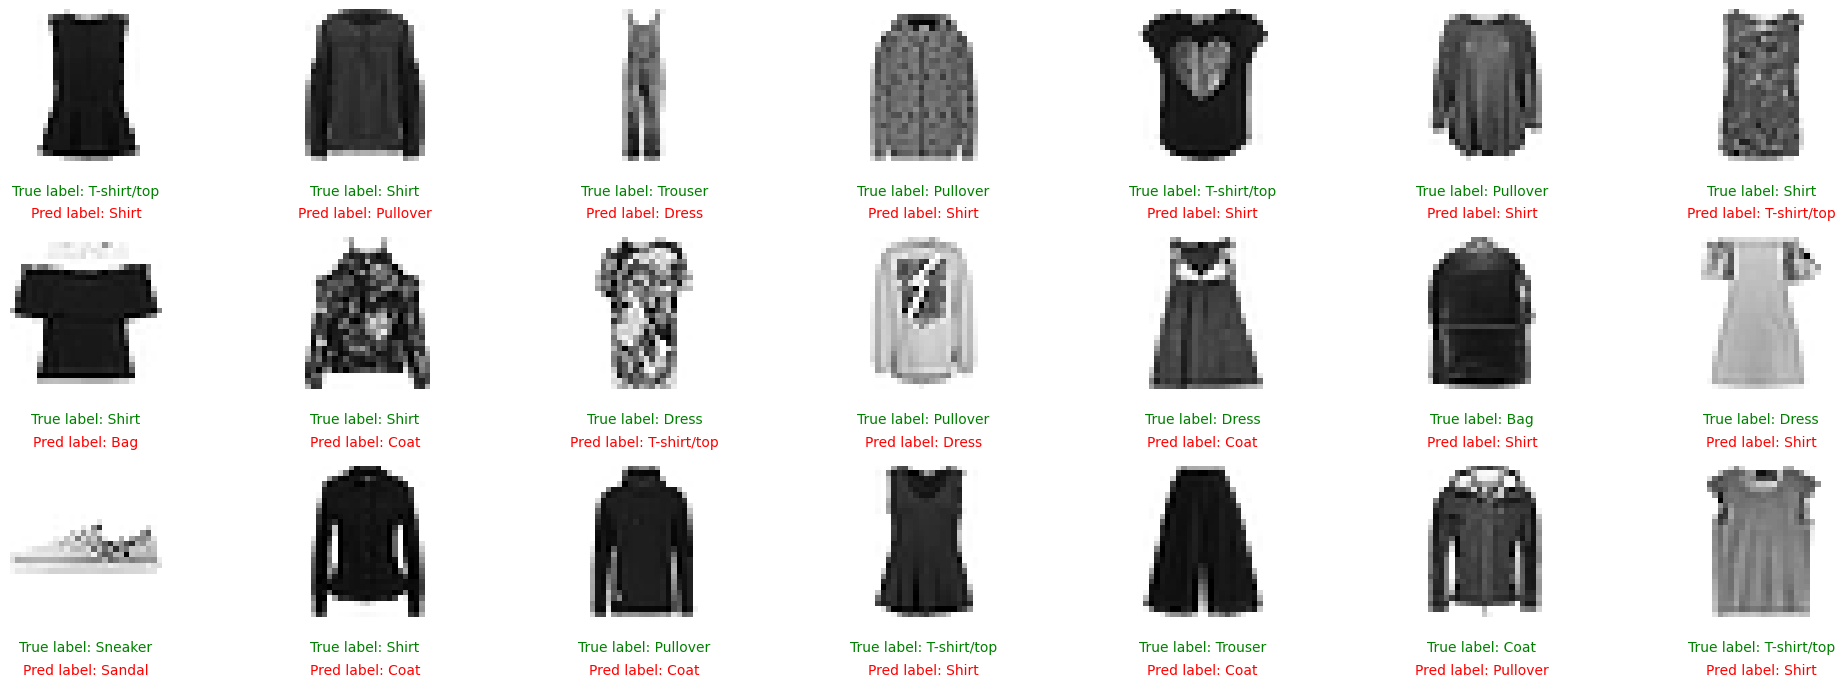

In [30]:
N = 21
random_indexes = np.random.choice(wrong_indexes, size=N, replace=False)
plt.figure(figsize=(20, 7))
n_cols = 7
n_rows = int(np.ceil(N/n_cols))


for row in range(n_rows):
    for col in range(n_cols):
        index = row * n_cols + col
        if index < N:
            plt.subplot(n_rows, n_cols, index + 1)
            image_index = random_indexes[index]
            right_label = y_test[image_index]
            wrong_label = y_pred_log_reg[image_index]
            image_data = X_test[image_index].reshape(28, 28)
            plt.imshow(image_data, cmap="binary")
            plt.axis("off")

            plt.text(
                0.5, -0.15, f"True label: {class_name[right_label]}", color="green", ha="center", va="top", transform=plt.gca().transAxes
            )
            plt.text(
                0.5, -0.3, f"Pred label: {class_name[wrong_label]}", color="red", ha="center", va="top", transform=plt.gca().transAxes
            )

plt.tight_layout()
plt.show()

**1. Similar Shape and Silhouette:**
- The model often misclassifies items with similar shapes or silhouettes, such as "T-shirt/top" as "Shirt" and "Pullover" as "Shirt." These types of clothing items share a similar outline, which can be hard to distinguish in grayscale or low-resolution images, as the model may struggle to capture subtle differences in collar shape, sleeve length, or fabric texture.

**2. Confusion between Clothing Categories:**

- Instances of "Dress" are often predicted as "Coat" or "T-shirt/top." Dresses and coats can sometimes have similar lengths and shapes, particularly when rendered in grayscale, making it challenging for the model to differentiate between these items without additional color or texture information.

**3. Accessory and Clothing Misclassification:**

- There are examples where items like "Bag" and "Shirt" are confused, likely due to the presence of rectangular shapes in bags that can resemble certain shirt outlines in low-resolution images. This type of error suggests that the model may need to learn more specific features related to accessories versus apparel to avoid such confusion.
    
**4. Footwear Confusion:**

- The model occasionally mistakes "Sneaker" for "Sandal," possibly because both share similar shapes, especially in simplified images. This error suggests that the model might not be fully capturing unique footwear characteristics, like the open design of sandals versus the closed structure of sneakers.